# characters classification model:

In [ ]:
import numpy as np

arr = np.loadtxt("characters.csv",
                 delimiter=",", dtype=str)
display(arr)

array([['45', '0', '0', ..., '0', '0', '0'],
       ['36', '0', '0', ..., '0', '0', '0'],
       ['43', '0', '0', ..., '0', '0', '0'],
       ...,
       ['23', '0', '0', ..., '0', '0', '0'],
       ['31', '0', '0', ..., '0', '0', '0'],
       ['8', '0', '0', ..., '0', '0', '0']], dtype='<U3')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

labels = []
images = []

for row in arr:
  lb = int(row[0])
  labels.append(lb)

  img_arr = np.array(row[1:], dtype=np.uint8)
  img_arr = img_arr.reshape(28, 28).T
  img = Image.fromarray(img_arr)
  images.append(img)

In [ ]:
print(len(images))
print(len(labels))

112800
112800


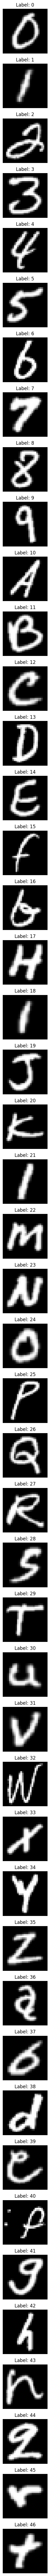

In [ ]:
import matplotlib.pyplot as plt

unique_label_images = {}

for img, lb in zip(images, labels):
    if lb not in unique_label_images:
        unique_label_images[lb] = img

sorted_labels = sorted(unique_label_images.keys())

plt.figure(figsize=(10, len(sorted_labels) * 2))

for idx, lb in enumerate(sorted_labels):
    img = unique_label_images[lb]
    plt.subplot(len(sorted_labels), 1, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {lb}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class_to_char = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5',
    6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B',
    12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H',
    18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N',
    24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g',
    42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'
}

In [ ]:
import pandas as pd

df = pd.DataFrame()
df['label'] = labels
df['image'] = images

print(df.head())

   label                                              image
0     45  <PIL.Image.Image image mode=L size=28x28 at 0x...
1     36  <PIL.Image.Image image mode=L size=28x28 at 0x...
2     43  <PIL.Image.Image image mode=L size=28x28 at 0x...
3     15  <PIL.Image.Image image mode=L size=28x28 at 0x...
4      4  <PIL.Image.Image image mode=L size=28x28 at 0x...


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx]['label']
        image = self.dataframe.iloc[idx]['image']

        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to match input size of CNN
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ImageDataset(train_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NetCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 47)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = NetCNN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(4):
    net.train()
    running_loss = 0.0
    i=0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        i += 1
        if i % 500 == 499:
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss /100:.3f}')
          running_loss = 0.0

print('Finished Training')

[1,   500] loss: 19.189
[1,  1000] loss: 18.888
[1,  1500] loss: 11.922
[1,  2000] loss: 7.041
[1,  2500] loss: 5.400
[2,   500] loss: 4.241
[2,  1000] loss: 3.818
[2,  1500] loss: 3.552
[2,  2000] loss: 3.352
[2,  2500] loss: 3.212
[3,   500] loss: 2.988
[3,  1000] loss: 2.872
[3,  1500] loss: 2.778
[3,  2000] loss: 2.698
[3,  2500] loss: 2.609
[4,   500] loss: 2.524
[4,  1000] loss: 2.490
[4,  1500] loss: 2.430
[4,  2000] loss: 2.360
[4,  2500] loss: 2.414
Finished Training


In [ ]:
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total}%")


Accuracy: 83.51063829787235%


# Transfer Learning
 from the Keras Handwritten Character Recognition Model (https://github.com/srijan14/keras-handwritten-character-recognition?utm_source=chatgpt.com)

In [ ]:
!git clone https://github.com/srijan14/keras-handwritten-character-recognition
!cd keras-handwritten-character-recognition

Cloning into 'keras-handwritten-character-recognition'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 216 (delta 34), reused 8 (delta 8), pack-reused 167 (from 1)
Receiving objects: 100% (216/216), 37.70 MiB | 14.82 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [ ]:
!pip install tensorflow keras numpy

In [ ]:
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [ ]:
from tensorflow.keras.models import load_model

model_path = 'keras-handwritten-character-recognition/models/model.h5'
pretrained_model = load_model(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
pretrained_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 62)                  │           7,998 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,475,520 (9.44 MB)

 Trainable params: 2,475,518 (9.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
from tensorflow.keras.layers import Dense

# Add a new Dense layer for classification
num_classes = 47  # Adjust to your dataset
pretrained_model.add(Dense(num_classes, activation='softmax',name='Dense_4'))

In [ ]:
pretrained_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 62)                  │           7,998 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_4 (Dense)                      │ (None, 47)                  │           2,961 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,478,481 (9.45 MB)

 Trainable params: 2,478,479 (9.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
for layer in pretrained_model.layers[:-2]:  # Freeze all but the last two layer
    layer.trainable = False

In [ ]:
import keras

pretrained_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set, y_train, y_test = train_test_split(images,labels, test_size=0.2, random_state=42)

In [ ]:
import numpy as np

pretrained_model.fit(
    x=np.array(train_set),
    y=np.array(y_train),
    batch_size=32,
    epochs=3,
    verbose="auto",
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
)


Epoch 1/3
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.4413 - loss: 3.1010
Epoch 2/3
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.5468 - loss: 1.4635
Epoch 3/3
2820/2820 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5553 - loss: 1.1297


In [ ]:
pretrained_model.evaluate(
    x=np.array(test_set),
    y=np.array(y_test),
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    return_dict=False,
)


705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5682 - loss: 1.0495


[1.0543454885482788, 0.5672872066497803]

# working on the sentences data set:

In [ ]:
import os

file_path = 'train_sentences.json'
print("File size:", os.path.getsize(file_path), "bytes")

File size: 6263909 bytes


In [ ]:
import json

with open('train_sentences.json', 'r') as file:
    content = file.read()

try:
    data = json.loads(content)
    print(data)
except json.JSONDecodeError as e:
    print("Error decoding JSON:", e)
    print("File content:", content[:50])  # Print the first 50 characters for review


[{'sentence_id': 'b9e1635a-72aa-467f-86d6-f56ef09f62c3', 'image_paths': ['./images/2f962f8d7adb43c297c5944cdf445496.png', './images/f6e9cc8f6ac84cc48364f1fbcdc329ff.png', './images/c0358b9d97f943c090ba89ac4d22c491.png', './images/803c3037be514be9aed85e99cc65fc7c.png', ' ', './images/108ab9369cf842719eb3751caa3b933b.png', './images/376c09cb889b48c499f3718dd59f10c5.png', './images/736ca182a6c64ef7bfa7099030e964a2.png', ' ', './images/454bc36526194862936aae85aa0787c8.png', './images/bd904d7fe0f74daa8159f5dc7131ebb1.png', './images/f5f31c9de2774404b67d3834ab9d43d8.png', ' ', './images/de34d04c76804606b345c358cc48d0fe.png', './images/69e65c96404b486f85ac211c6bb9ac2a.png', './images/84f4719aa12647a38c5c67fa39f05380.png', './images/1512060d670440b0997d6d030753434a.png', ' ', './images/e134a7416ccb4955949816a2d8582309.png', './images/85ccc71161c74527ae0bab0dbcbe8826.png', './images/88d514c8d7da4e7aa764867af0163225.png', './images/cfb64dc7621c4734a993726da9256146.png', ' ', './images/e37f89e4cf

In [ ]:
import json

with open('train_sentences.json', 'r') as file:
    data = json.load(file)

print(data)

[{'sentence_id': 'b9e1635a-72aa-467f-86d6-f56ef09f62c3', 'image_paths': ['./images/2f962f8d7adb43c297c5944cdf445496.png', './images/f6e9cc8f6ac84cc48364f1fbcdc329ff.png', './images/c0358b9d97f943c090ba89ac4d22c491.png', './images/803c3037be514be9aed85e99cc65fc7c.png', ' ', './images/108ab9369cf842719eb3751caa3b933b.png', './images/376c09cb889b48c499f3718dd59f10c5.png', './images/736ca182a6c64ef7bfa7099030e964a2.png', ' ', './images/454bc36526194862936aae85aa0787c8.png', './images/bd904d7fe0f74daa8159f5dc7131ebb1.png', './images/f5f31c9de2774404b67d3834ab9d43d8.png', ' ', './images/de34d04c76804606b345c358cc48d0fe.png', './images/69e65c96404b486f85ac211c6bb9ac2a.png', './images/84f4719aa12647a38c5c67fa39f05380.png', './images/1512060d670440b0997d6d030753434a.png', ' ', './images/e134a7416ccb4955949816a2d8582309.png', './images/85ccc71161c74527ae0bab0dbcbe8826.png', './images/88d514c8d7da4e7aa764867af0163225.png', './images/cfb64dc7621c4734a993726da9256146.png', ' ', './images/e37f89e4cf

In [ ]:
import pandas as pd

train_df = pd.DataFrame(data)
print(train_df.head(3))

                            sentence_id  \
0  b9e1635a-72aa-467f-86d6-f56ef09f62c3   
1  f99b5143-70d2-494a-a2f5-c68f10d09d0a   
2  4076639c-aa56-4202-ae0f-9d9217f8da68   

                                         image_paths label  
0  [./images/2f962f8d7adb43c297c5944cdf445496.png...  SUBJ  
1  [./images/f1669c6a48fd4fc085d893bbcabd3b5f.png...   OBJ  
2  [./images/b52e13be4e8f471ebbc2ff7abc630220.png...   OBJ  


In [ ]:
print(train_df['image_paths'].head(1))

0    [./images/2f962f8d7adb43c297c5944cdf445496.png...
Name: image_paths, dtype: object


In [ ]:
import zipfile
import os

with zipfile.ZipFile('images.zip', 'r') as zip_ref:
    zip_ref.extractall("images")

(28, 28, 3)


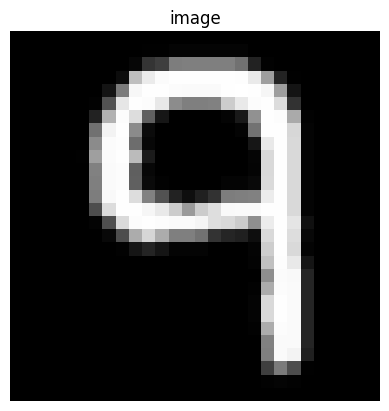

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./images/images/0d1e67726ce14a44b4d816308d74b7d2.png')

print(img.shape)

plt.imshow(img, cmap='gray')
plt.title('image')
plt.axis('off')
plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt

def extract_image(paths):
  if(paths == None):
    print("this paths or image list is non existence")

  if(paths == " "):
    print("this paths or images list is empty")

  images = []
  for path in paths:

    if(path == ' '):
      images.append("Space")
      continue

    path = path.strip('.')
    path = './images' + path[0:]
    img = cv2.imread(path)
    images.append(img)

  return images

In [ ]:
train_df['images'] = train_df['image_paths'].apply(lambda x: extract_image(x))

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_id  830 non-null    object
 1   image_paths  830 non-null    object
 2   label        830 non-null    object
 3   images       830 non-null    object
dtypes: object(4)
memory usage: 26.1+ KB
None


In [ ]:
print(train_df['images'].head(2))

0    [[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]...
1    [[[[0 0 0], [0 0 0], [0 0 0], [0 0 0], [0 0 0]...
Name: images, dtype: object


# constructing the scentences:

In [ ]:
from PIL import Image
import numpy as np

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((32, 32)),                 # Resize to model's input size
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))         # Normalize
])

def costruct_scentence(images):
  #images =  row['images']


  scentence = []
  for image in images:
    if(len(image) <= 5 or type(image) == str):
      scentence.append(" ")
      continue

    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)

    input_tensor = transform(image).unsqueeze(0)
    input_tensor = input_tensor.to(device)

    net.eval()
    with torch.no_grad():
        output = net(input_tensor)

    predicted_class = torch.argmax(output, dim=1).item()
    # print(f'Predicted class: {predicted_class}')

    scentence.append(predicted_class)

  #print(scentence)
  return scentence

In [ ]:
row = train_df.iloc[0]
sentence = costruct_scentence(row['images'])

In [ ]:
# Convert the sentence from class indices to characters
def classes_to_characters(sentence):
    return ''.join([class_to_char[cls] if cls != ' ' else ' ' for cls in sentence])

decoded_sentence = classes_to_characters(sentence)
print(f"Decoded sentence: {decoded_sentence}")

Decoded sentence: GOWE ARE THE DAYS WHEN THEr 1ED THZ WORLD IN RECESSIONBUSrIN6


In [ ]:
def predicted_scentences(images):
  predicted_classes = costruct_scentence(images)
  decoded_sentence = classes_to_characters(predicted_classes)
  return decoded_sentence

In [ ]:
train_df['scentence'] = train_df['images'].apply(lambda x: predicted_scentences(x))

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence_id  830 non-null    object
 1   image_paths  830 non-null    object
 2   label        830 non-null    object
 3   images       830 non-null    object
 4   scentence    830 non-null    object
dtypes: object(5)
memory usage: 32.5+ KB
None


In [ ]:
print(train_df['scentence'].head())

0    GOWE ARE THE DAYS WHEN THEr 1ED THZ WORLD IN R...
1    tWE TREND IS EXPECTED TO REJERSE AS JDON fS NE...
2                BUT tHERE IS THE SPEC1OUS P0INT AGA1N
3    HE ADDED HE WOVLhVT BE SURPRLSED TO SEE A NEW ...
4    NOT 1ESS G0VERNMENT YOU SEE THE SAMI AMOUNT Of...
Name: scentence, dtype: object


# Spelling Correction

In [ ]:
from textblob import TextBlob
scentence = train_df['scentence'][3]
words = scentence.split(" ")
corrected_words = []
for i in words:
    corrected_words.append(TextBlob(i))
print("Wrong words :", words)
print("Corrected Words are :")
for i in corrected_words:
    print(i.correct(), end=" ")

Wrong words : ['HE', 'ADDED', 'HE', 'WOVLhVT', 'BE', 'SURPRLSED', 'TO', 'SEE', 'A', 'NEW', 'VAR1ANT', 'ALTOGETHER', 'THIS', 'fMLL']
Corrected Words are :
of ADDED of WOVLhVT of SURPRLSED of SEE A NEW VAR1ANT ALTOGETHER THIS fMLL 

In [ ]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 70.5 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/barrust/pyspellchecker.git
!cd pyspellchecker
!python -m build

Cloning into 'pyspellchecker'...
remote: Enumerating objects: 1000, done.
remote: Counting objects: 100% (337/337), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 1000 (delta 190), reused 256 (delta 147), pack-reused 663 (from 1)
Receiving objects: 100% (1000/1000), 103.56 MiB | 24.80 MiB/s, done.
Resolving deltas: 100% (542/542), done.
/usr/bin/python3: No module named build


In [ ]:
!pip install pyspellchecker==0.5.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: pyspellchecker
    Found existing installation: pyspellchecker 0.8.2
    Uninstalling pyspellchecker-0.8.2:
      Successfully uninstalled pyspellchecker-0.8.2


In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

# find those words that may be misspelled
misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])

for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))

    # Get a list of `likely` options
    print(spell.candidates(word))

happenning
{'hapening', 'happenning'}


In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

# find those words that may be misspelled
scentence = train_df['scentence'][3]
words = scentence.split(" ")
misspelled = spell.unknown(words)

print(words)
for word in misspelled:
    # Get the one `most likely` answer
    print(spell.correction(word))

    # Get a list of `likely` options
    print(spell.candidates(word))

['HE', 'ADDED', 'HE', 'WOVLhVT', 'BE', 'SURPRLSED', 'TO', 'SEE', 'A', 'NEW', 'VAR1ANT', 'ALTOGETHER', 'THIS', 'fMLL']
surprised
{'surprised'}
wovlhvt
{'wovlhvt'}
full
{'fall', 'foll', 'fill', 'full', 'fell'}
variant
{'variant'}


In [ ]:
spell = SpellChecker()

def spell_checker(scentence):
  misspelled = scentence.split(" ")

  corrected_scentene = []
  for word in misspelled:
      corrected_scentene.append(spell.correction(word))

  # print(scentence)
  return ' '.join(corrected_scentene)

In [ ]:
train_df['corrected_scentence'] = train_df['scentence'].apply(lambda x: spell_checker(x))

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sentence_id          830 non-null    object
 1   image_paths          830 non-null    object
 2   label                830 non-null    object
 3   images               830 non-null    object
 4   scentence            830 non-null    object
 5   corrected_scentence  830 non-null    object
dtypes: object(6)
memory usage: 39.0+ KB
None


In [ ]:
print(train_df['corrected_scentence'].head())

0    gone ARE THE DAYS WHEN THEr red the WORLD IN R...
1    tWE TREND IS EXPECTED TO reverse AS don is NEX...
2                BUT tHERE IS THE specious point again
3    HE ADDED HE WOVLhVT BE surprised TO SEE A NEW ...
4    NOT less government YOU SEE THE SAMI AMOUNT Of...
Name: corrected_scentence, dtype: object


In [ ]:
train_df.to_csv('scentences_ready.csv')

# Text Pre-processing:

In [ ]:
print(train_df['label'].unique())

['SUBJ' 'OBJ']


In [ ]:
mapping = {'SUBJ': 0, 'OBJ': 1}
train_df['label'] = train_df['label'].map(mapping)

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sentence_id          830 non-null    object
 1   image_paths          830 non-null    object
 2   label                830 non-null    int64 
 3   images               830 non-null    object
 4   scentence            830 non-null    object
 5   corrected_scentence  830 non-null    object
dtypes: int64(1), object(5)
memory usage: 39.0+ KB
None


In [ ]:
import nltk
nltk.download('punkt', force=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenize(sentence):
    tokens = word_tokenize(sentence)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    return tokens

train_df['tokens'] = train_df['corrected_scentence'].apply(tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(train_df['tokens'].head())

0    [gone, afe, the, days, when, ther, ied, the, w...
1    [the, trend, is, expected, to, reverse, as, so...
2        [but, there, is, the, specious, point, again]
3    [he, added, he, wovinwt, be, surprised, to, se...
4    [not, less, government, kou, see, the, sama, a...
Name: tokens, dtype: object


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

train_df['tokens'] = train_df['tokens'].apply(remove_stopwords)

print(train_df['tokens'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0                         [gone, days, ther, red, world]
1           [twe, trend, expected, reverse, next, month]
2                                      [specious, point]
3      [added, wovlhvt, surprised, see, new, variant,...
4      [less, government, see, sami, amount, governme...
                             ...                        
825    [local, governments, nno, flnancljg, vehicles,...
826    [fact, alone, underscores, biggest, problem, o...
827    [presumably, mind, russian, officials, whose, ...
828    [bad, taxation, reckless, borrowing, reckless,...
829    [foreign, ministry, spokeswoman, maria, zakhar...
Name: tokens, Length: 830, dtype: object


In [ ]:
from gensim.models import Word2Vec
word_embedding = Word2Vec(train_df['tokens'], vector_size=100,
min_count=1, window=5, sg=1, hs=0, negative=10)

In [ ]:
word_embedding.save('w2v.model')
word_embedding = Word2Vec.load('w2v.model')

In [ ]:
import pandas as pd
import numpy as np

def filter_tokens(tokens):
    return [token for token in tokens if token in word_embedding.wv]

train_df['filtered_tokens'] = train_df['tokens'].apply(filter_tokens)

def mean_vector(tokens):
    if len(tokens) > 0:
        return word_embedding.wv[tokens].mean(axis=0)
    else:
        return np.zeros(word_embedding.vector_size)

train_df['mean_vector'] = train_df['filtered_tokens'].apply(mean_vector)

print(train_df[['filtered_tokens', 'mean_vector']])

                                       filtered_tokens  \
0                       [gone, days, ther, red, world]   
1         [twe, trend, expected, reverse, next, month]   
2                                    [specious, point]   
3    [added, wovlhvt, surprised, see, new, variant,...   
4    [less, government, see, sami, amount, governme...   
..                                                 ...   
825  [local, governments, nno, flnancljg, vehicles,...   
826  [fact, alone, underscores, biggest, problem, o...   
827  [presumably, mind, russian, officials, whose, ...   
828  [bad, taxation, reckless, borrowing, reckless,...   
829  [foreign, ministry, spokeswoman, maria, zakhar...   

                                           mean_vector  
0    [-0.07599994, 0.09705402, 0.06346472, 0.041742...  
1    [-0.09351363, 0.1277874, 0.09089568, 0.0602830...  
2    [-0.09306445, 0.12482874, 0.089335516, 0.05700...  
3    [-0.109779984, 0.14286207, 0.099941894, 0.0673...  
4    [-0.18401197,

In [ ]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sentence_id          830 non-null    object
 1   image_paths          830 non-null    object
 2   label                830 non-null    int64 
 3   images               830 non-null    object
 4   scentence            830 non-null    object
 5   corrected_scentence  830 non-null    object
 6   tokens               830 non-null    object
 7   filtered_tokens      830 non-null    object
 8   mean_vector          830 non-null    object
dtypes: int64(1), object(8)
memory usage: 58.5+ KB
None


In [ ]:
import numpy as np
X = np.array(train_df['mean_vector'])
y = np.array(train_df['label'])

# Long Short-Term Memory (LSTM)

In [ ]:
def vectorize(tokens):
    return np.array([word_embedding.wv[token] for token in tokens if token in word_embedding.wv])

train_df['vectors'] = train_df['filtered_tokens'].apply(vectorize)

print(train_df[['filtered_tokens', 'vectors']])

                                       filtered_tokens  \
0                       [gone, days, ther, red, world]   
1         [twe, trend, expected, reverse, next, month]   
2                                    [specious, point]   
3    [added, wovlhvt, surprised, see, new, variant,...   
4    [less, government, see, sami, amount, governme...   
..                                                 ...   
825  [local, governments, nno, flnancljg, vehicles,...   
826  [fact, alone, underscores, biggest, problem, o...   
827  [presumably, mind, russian, officials, whose, ...   
828  [bad, taxation, reckless, borrowing, reckless,...   
829  [foreign, ministry, spokeswoman, maria, zakhar...   

                                               vectors  
0    [[-0.056120865, 0.062070865, 0.040092684, 0.02...  
1    [[-0.28479335, 0.37221345, 0.25779903, 0.17849...  
2    [[0.0018299929, 0.012776723, 0.0068718614, -0....  
3    [[-0.06360717, 0.08758782, 0.06637105, 0.05053...  
4    [[-0.23179582

In [ ]:
import torch
import torch.nn as nn

input_size = 100
hidden_size = 200
num_layers = 1

lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

sequence = torch.tensor(train_df['vectors'][0], dtype=torch.float)
sequence = sequence.unsqueeze(0)

out, (hidden_state, cell_state) = lstm(sequence)

print(f"Output shape: {out.shape}")
print(f"Hidden state shape: {hidden_state.shape}")
print(f"Cell state shape: {cell_state.shape}")

Output shape: torch.Size([1, 5, 200])
Hidden state shape: torch.Size([1, 1, 200])
Cell state shape: torch.Size([1, 1, 200])


In [ ]:
pad_vector = np.zeros(word_embedding.vector_size)
weights = np.vstack([word_embedding.wv.vectors, pad_vector])
vocab_size, embedding_size = weights.shape
pad_idx = vocab_size - 1

In [ ]:
import torch.nn.functional as F
class SentimentClassifierLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size,
    num_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers,
    batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)
  def forward(self, x):
      embeddings = self.embedding(x)
      out, _ = self.lstm(embeddings)
      out = out[:, -1, :]  # Get the output for the last time step
      out = self.fc(out)
      out = torch.sigmoid(out)  # Use torch.sigmoid instead of F.sigmoid (deprecated)
      return out  # Do not squeeze here; keep the shape as [batch_size, 1]

In [ ]:
hidden_size = 128
num_layers = 2
model = SentimentClassifierLSTM(vocab_size=vocab_size,
        embedding_size=embedding_size, hidden_size=hidden_size,
        num_layers=num_layers)
model.embedding.weight = nn.Parameter(torch.FloatTensor(weights))
model.embedding.weight.requires_grad = False

In [ ]:
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

# train the model:

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
all_tokens = [word for tokens in train_df["filtered_tokens"] for word in tokens]
vocab = sorted(set(all_tokens))
word2index = {word: idx for idx, word in enumerate(vocab, start=1)}  # Start indexing from 1
word2index["<PAD>"] = 0
print(word2index)

{'ab': 1, 'aback': 2, 'ability': 3, 'able': 4, 'abnormal': 5, 'abour': 6, 'absolutely': 7, 'absorb': 8, 'absorbed': 9, 'absorbing': 10, 'academic': 11, 'accelerated': 12, 'accept': 13, 'acceptable': 14, 'accepted': 15, 'accepting': 16, 'access': 17, 'according': 18, 'account': 19, 'accounted': 20, 'accounts': 21, 'accused': 22, 'accusing': 23, 'ace': 24, 'achieving': 25, 'acid': 26, 'acquired': 27, 'acquiring': 28, 'acquisitions': 29, 'across': 30, 'act': 31, 'acting': 32, 'action': 33, 'activated': 34, 'actively': 35, 'activists': 36, 'activities': 37, 'acts': 38, 'actually': 39, 'actuals': 40, 'acute': 41, 'ad': 42, 'adal': 43, 'add': 44, 'added': 45, 'addition': 46, 'additional': 47, 'address': 48, 'addressing': 49, 'adequately': 50, 'adjudicate': 51, 'adjustment': 52, 'administer': 53, 'administration': 54, 'administrations': 55, 'administrative': 56, 'administrators': 57, 'admirable': 58, 'admission': 59, 'admit': 60, 'admitted': 61, 'admlnlstratidn': 62, 'adopted': 63, 'adoption'

In [ ]:
def tokens_to_indices(tokens, word2index):
    return [word2index.get(word, 0) for word in tokens]

train_df["token_indices"] = train_df["filtered_tokens"].apply(lambda tokens: tokens_to_indices(tokens, word2index))
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 664 entries, 530 to 102
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   sentence_id          664 non-null    object
 1   image_paths          664 non-null    object
 2   label                664 non-null    int64 
 3   images               664 non-null    object
 4   scentence            664 non-null    object
 5   corrected_scentence  664 non-null    object
 6   tokens               664 non-null    object
 7   filtered_tokens      664 non-null    object
 8   mean_vector          664 non-null    object
 9   vectors              664 non-null    object
 10  token_indices        664 non-null    object
dtypes: int64(1), object(10)
memory usage: 62.2+ KB
None


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, dataframe, word2index, max_len):
        self.data = dataframe
        self.word2index = word2index
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens = self.data.iloc[idx]["filtered_tokens"]
        label = float(self.data.iloc[idx]["label"])
        indices = [self.word2index.get(token, 0) for token in tokens]
        indices = indices[:self.max_len]
        padded_indices = indices + [0] * (self.max_len - len(indices))
        return torch.tensor(padded_indices, dtype=torch.long), torch.tensor(label, dtype=torch.float)

max_len = 50
dataset = SentimentDataset(train_df, word2index, max_len)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(SentimentDataset(val_df, word2index, max_len), batch_size=32)

In [ ]:
import torch.nn as nn
import torch.optim as optim

vocab_size = len(word2index)
embedding_size = 100
hidden_size = 128
num_layers = 2

model = SentimentClassifierLSTM(vocab_size, embedding_size, hidden_size, num_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)  # Outputs should have shape [batch_size, 1]
      outputs = outputs.squeeze(1)  # Squeeze to match labels shape [batch_size]
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()


    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/2, Loss: 0.0000
Epoch 2/2, Loss: 0.0000


In [ ]:
model.eval()
val_loss = 0.0

epochs = 2
for epoch in range(epochs):
  with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        outputs = outputs.squeeze(1)  # Ensure shape [batch_size]
        loss = criterion(outputs, labels)
  print(f"Validation Loss: {val_loss/len(val_loader):.4f}")


Validation Loss: 0.0000
Validation Loss: 0.0000
